# Chapter 17: Decision Trees

In this chapter we will implement a decision tree classifier. The decision tree will use entropy minimization for partion selection.

### Entropy

Entropy is a measure of uncertainty: the lower the entropy, the lower the uncertainty. If we have a set of data $S$ consisting of observations with a finite set of labels $C_1, C_2, \ldots C_n$. If each each class $C_i$ has corresponding proportion $p_i$,  the entropy of $S$ can then be defined as:

$\displaystyle H(S) = -p_1 \log_2(p_1) - \cdots - p_n \log_2(p_n) = - \sum_{i=1}^n p_i \log_2(p_i)$

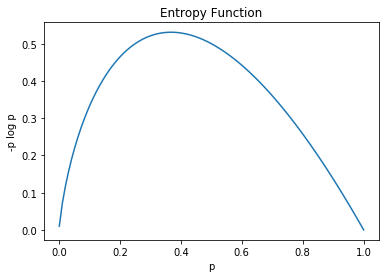

In [1]:
import math, my_utils
from collections import Counter, defaultdict
from matplotlib import pyplot
from functools import partial
%matplotlib inline


def p_log_p(p):
    return -p * math.log(p, 2)

if __name__ == "__main__":
    x = my_utils.linspace(0.001,1,100)
    y = [p_log_p(x_i) for x_i in x]
    pyplot.plot(x, y)
    pyplot.title("Entropy Function")
    pyplot.xlabel("p")
    pyplot.ylabel("-p log p")

In [2]:
def entropy(class_probabilities):
    """Given a list of class probabilities, compute the entropy"""
    return sum(p_log_p(p)
               for p in class_probabilities if p)

def class_probabilities(labels):
    total_count = len(labels)
    return [count / total_count for count in Counter(labels).values()]

def data_entropy(labeled_data):
    labels = [label for _, label in labeled_data]
    probs = class_probabilities(labels)
    return entropy(probs)

### Entropy of a Partition

Given some partitioning of our dataset into subsets $S_1, \ldots, S_n$ with corresponding proportions $q_1, \ldots, q_n$ then the entropy of that partitioning  is the weighted sum:

$\displaystyle H = q_1 H(S_1) + \cdots + q_n H(S_n) = \sum_i q_i H(S_i)$

In [3]:
def partition_entropy(subsets):
    """find the entropy from this partition of the data into subsets"""
    total_count = sum(len(subset) for subset in subsets)
    
    return sum(data_entropy(subset) * len(subset) / total_count 
               for subset in subsets)

In [4]:
if __name__ == "__main__":
    inputs = [({'level':'Senior', 'lang':'Java', 'tweets':'no', 'phd':'no'}, False),
        ({'level':'Senior','lang':'Java','tweets':'no','phd':'yes'}, False), 
        ({'level':'Mid', 'lang':'Python', 'tweets':'no', 'phd':'no'}, True), 
        ({'level':'Junior','lang':'Python','tweets':'no','phd':'no'}, True),
        ({'level':'Junior', 'lang':'R', 'tweets':'yes', 'phd':'no'},      True),
        ({'level':'Junior', 'lang':'R', 'tweets':'yes', 'phd':'yes'},     False),
        ({'level':'Mid', 'lang':'R', 'tweets':'yes', 'phd':'yes'},         True),
        ({'level':'Senior', 'lang':'Python', 'tweets':'no', 'phd':'no'},  False),
        ({'level':'Senior', 'lang':'R', 'tweets':'yes', 'phd':'no'},       True),
        ({'level':'Junior', 'lang':'Python', 'tweets':'yes', 'phd':'no'},  True),
        ({'level':'Senior', 'lang':'Python', 'tweets':'yes', 'phd':'yes'}, True),
        ({'level':'Mid', 'lang':'Python', 'tweets':'no', 'phd':'yes'},     True),
        ({'level':'Mid', 'lang':'Java', 'tweets':'yes', 'phd':'no'},       True),
        ({'level':'Junior', 'lang':'Python', 'tweets':'no', 'phd':'yes'}, False)]

In [5]:
def partition_by(inputs, attribute):
    """each input is a pair (attribute_dict, label)
    returns a dict : attribute => inputs"""
    groups = defaultdict(list)
    for input in inputs:
        key = input[0][attribute] # get the value of the specified attribute
        groups[key].append(input) # then add this input to the correct list
    return groups

def partition_entropy_by(inputs, attribute):
    """computes the entropy corresponding to the given partition"""
    partitions = partition_by(inputs, attribute)
    return partition_entropy(partitions.values())

### Trying out partitioning

In [6]:
if __name__ == "__main__":
    for attr in ['level','lang','tweets','phd']: 
        print("{}:\t {:1.3f}".format(attr, partition_entropy_by(inputs, attr)))

level:	 0.694
lang:	 0.860
tweets:	 0.788
phd:	 0.892


### Constructing a Tree
For the purpose of this algorithm we will implement a barebones tree structure where each node is either `True` or `False` (these being the leaf nodes) or a `(attr, subtree_dict)` tuple.

Note that for attribute values not present in the training data we will no corresponding subtree. For these cases we will simply apply the most common decision label.

In [7]:
def classify(tree, input):
    """classify the input given a decision tree"""
    
    # if the tree is a leaf node, return the value
    if tree in [True, False]:
        return tree
    
    # otherwise this tree consists of an attribute to split on
    # and a dictionary whose keys are values of that attribute
    # and whose values are subtrees to consider next
    attribute, subtree_dict = tree
    
    subtree_key = input.get(attribute)     # None if attribute not present
    
    if subtree_key not in subtree_dict:    # if no subtree for key,
        subtree_key = None                 # we'll use the None subtree
    
    subtree = subtree_dict[subtree_key]    # choose the most appropriate subtree
    return classify(subtree, input)        # and use it to classify the input

def build_tree_id3(inputs, split_candidates=None):
    
    # if this is a first pass,
    # all of the keys on the first input are split candidates
    if split_candidates is None:
        split_candidates = inputs[0][0].keys()
        
    # counts true and falses in the inputs
    num_inputs = len(inputs)
    num_true = len([label for _, label in inputs if label])
    num_false = num_inputs - num_true
    
    if num_true == 0: return False     # no trues? return false
    if num_false == 0: return True      # no falses? return true
    
    if not split_candidates:            # if no splits left,  
        return num_true >= num_falses  # return the majority leaf
    
    # otherwise split on the best attribute 
    best_attr = min(split_candidates, 
                    key=partial(partition_entropy_by, inputs))
    
    partitions = partition_by(inputs, best_attr)
    new_candidates = [a for a in split_candidates if a != best_attr]
    
    # rescursively build the subtrees
    subtrees = {attribute_value: build_tree_id3(subset, new_candidates)
                for attribute_value, subset in partitions.items()}
    
    subtrees[None] = num_true > num_false # default case
    
    return (best_attr, subtrees)

### Build and Apply Tree

In [8]:
if __name__ == "__main__":
    tree = build_tree_id3(inputs)
    
    print(tree)
    
    class1 = classify(tree, { "level" : "Junior",
                 "lang" : "Java",
                 "tweets" : "yes",
                 "phd" : "no"} )
    
    print("The class of input one is {0}".format(class1))
    
    class2 = classify(tree, { "level" : "Junior",
                 "lang" : "Java",
                 "tweets" : "yes",
                 "phd" : "yes"} )
    
    print("The class of input two is {0}".format(class2))

('level', {'Mid': True, None: True, 'Senior': ('tweets', {'no': False, 'yes': True, None: False}), 'Junior': ('phd', {'no': True, 'yes': False, None: True})})
The class of input one is True
The class of input two is False


### Random Forests
As written, our decision tree will fit the training data perfectly. Clearly this will lead to masssive overfitting. There are several ways to change the Decision Tree implementation in order to fix the overfitting issue.

Instead of considering those approaches we will implement a Random Forest model. Random Forests consist of a collection of Decision Trees which vote on which class to apply. Ideally these tree would be sufficiently varied in order to prevent the same overfitting issues.

#### Random Forest Classifier

In [16]:
def forest_classify(trees, input):
    votes = [classify(tree, input) for tree in trees]
    vote_counts = Counter(votes)
    return vote_counts.most_common(1)[0][0]

#### Bootstrap Aggregating (Bagging)

There are two different ways of making the random decision trees. First is Bootstrap Aggregating or Bagging. Bagging is the method of training a model on different subsets of the overall training set. IF we sample properly the trees we get from this method is sufficiently diverse.

#### Ensembling

Rather than vary the data used to train the tree, Ensembling changes the way the tree is formed. At each split decision we only consider a random subset of all of the features.

```
# if there's already few enough split candidates, look at all of them
if len(split_candidates) <= self.num_split_candidates:
sampled_split_candidates = split_candidates
# otherwise pick a random sample
else:
sampled_split_candidates = random.sample(split_candidates,
self.num_split_candidates)
# now choose the best attribute only from those candidates
best_attribute = min(sampled_split_candidates,
key=partial(partition_entropy_by, inputs))
partitions = partition_by(inputs, best_attribute)
```

By proceeding in this manner the trees should be sufficiently de-correlated for use in our random classifier